In [56]:
import os
from pathlib import Path
import random
import zipfile

import kaggle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf

random_state = random.randint(1,999)
display(random_state)

# COnfiguraciones para tensorflow
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2024-10-05 23:25:41.479700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 23:25:41.541232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 23:25:41.554920: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


722

In [2]:
# Download data from kaggle

RAW_DATA_ZIP = "data/raw/data2/rsud20k-bangladesh-road-scene-understanding.zip"
EXTRACTED_DATA = "data/preprocessed/data2"

dataset = "hasibzunair/rsud20k-bangladesh-road-scene-understanding"
kaggle.api.dataset_download_files(dataset, path='data/raw/data2')

with zipfile.ZipFile(RAW_DATA_ZIP, 'r') as zip_ref:
        zip_ref.extractall(EXTRACTED_DATA)
        print(f"Extracted all files to {EXTRACTED_DATA}")

DATA_DIR = Path("data/preprocessed/data2/rsud20k")
DATA_DIR

Dataset URL: https://www.kaggle.com/datasets/hasibzunair/rsud20k-bangladesh-road-scene-understanding
Extracted all files to data/preprocessed/data2


PosixPath('data/preprocessed/data2/rsud20k')

In [49]:
def generate_and_validate_paths(data_dir):
    subdirs = ['images', 'labels']
    categories = ['test', 'train', 'val']
    folder_dict = {}

    print("Printing folder paths and checking their validity:")
    for subdir in subdirs:
        for category in categories:
            folder_name = f"{subdir}_{category}"
            folder_path = data_dir / subdir / category
            folder_dict[folder_name] = folder_path
            print(f"{folder_name}: {folder_path}")
            print(f"Is the path valid?: {folder_path.exists()}")

    return folder_dict

folder_dict = generate_and_validate_paths(DATA_DIR)
folder_dict

Printing folder paths and checking their validity:
images_test: data/preprocessed/data2/rsud20k/images/test
Is the path valid?: True
images_train: data/preprocessed/data2/rsud20k/images/train
Is the path valid?: True
images_val: data/preprocessed/data2/rsud20k/images/val
Is the path valid?: True
labels_test: data/preprocessed/data2/rsud20k/labels/test
Is the path valid?: True
labels_train: data/preprocessed/data2/rsud20k/labels/train
Is the path valid?: True
labels_val: data/preprocessed/data2/rsud20k/labels/val
Is the path valid?: True


{'images_test': PosixPath('data/preprocessed/data2/rsud20k/images/test'),
 'images_train': PosixPath('data/preprocessed/data2/rsud20k/images/train'),
 'images_val': PosixPath('data/preprocessed/data2/rsud20k/images/val'),
 'labels_test': PosixPath('data/preprocessed/data2/rsud20k/labels/test'),
 'labels_train': PosixPath('data/preprocessed/data2/rsud20k/labels/train'),
 'labels_val': PosixPath('data/preprocessed/data2/rsud20k/labels/val')}

In [51]:
def generate_image_paths(data_dir):
    subdirs = ['images']
    data_dir = Path(data_dir)
    images_folder = data_dir / subdirs[0]
    categories = ['test', 'train', 'val']
    folder_paths = [images_folder / category for category in categories]
    train_folder = images_folder / 'train'
    train_images = list(train_folder.glob('*'))
    return folder_paths, train_images

def process_image_folders(folder_list, img_ext):
    img_name_list = []
    img_width_list = []
    img_height_list = []
    img_folder_list = []
    img_format_list = []

    for folder in folder_list:
        parent_name = folder.name
        for img_path in folder.iterdir():
            if img_path.is_file():
                img_folder_list.append(parent_name)
                img_name_list.append(img_path.name)

                img_format = img_path.suffix.lower()
                img_format_list.append(
                    "ok" if img_format in img_ext else "not ok")

                with Image.open(img_path) as img:
                    width, height = img.size
                    img_width_list.append(width)
                    img_height_list.append(height)

    data_model = {
        "folder": img_folder_list,
        "image_name": img_name_list,
        "width": img_width_list,
        "height": img_height_list,
        "format": img_format_list
    }

    return pd.DataFrame(data=data_model)

IMAGE_EXT = {'.jpg', '.jpeg', '.png'}
LABEL_EXT = {'.txt'}
folder_list, train_images = generate_image_paths(DATA_DIR)
report_df = process_image_folders(folder_list, IMAGE_EXT)

In [52]:
report_df_group = report_df.groupby(
    ['folder', 'format', 'width', 'height']).count()
report_df_group

,,,,image_name
folder,format,width,height,
test,ok,1920,1080,649
train,ok,1920,1080,18681
val,ok,1920,1080,1004


In [53]:
# Shuffle train images
random.shuffle(train_images)
selected_images = train_images[:9]

print("Selected image paths after shuffle:")
for img in selected_images:
    print(img)

Selected image paths after shuffle:
data/preprocessed/data2/rsud20k/images/train/train12183.jpg
data/preprocessed/data2/rsud20k/images/train/train5003.jpg
data/preprocessed/data2/rsud20k/images/train/train1392.jpg
data/preprocessed/data2/rsud20k/images/train/train15634.jpg
data/preprocessed/data2/rsud20k/images/train/train15733.jpg
data/preprocessed/data2/rsud20k/images/train/train17699.jpg
data/preprocessed/data2/rsud20k/images/train/train10163.jpg
data/preprocessed/data2/rsud20k/images/train/train8237.jpg
data/preprocessed/data2/rsud20k/images/train/train17197.jpg


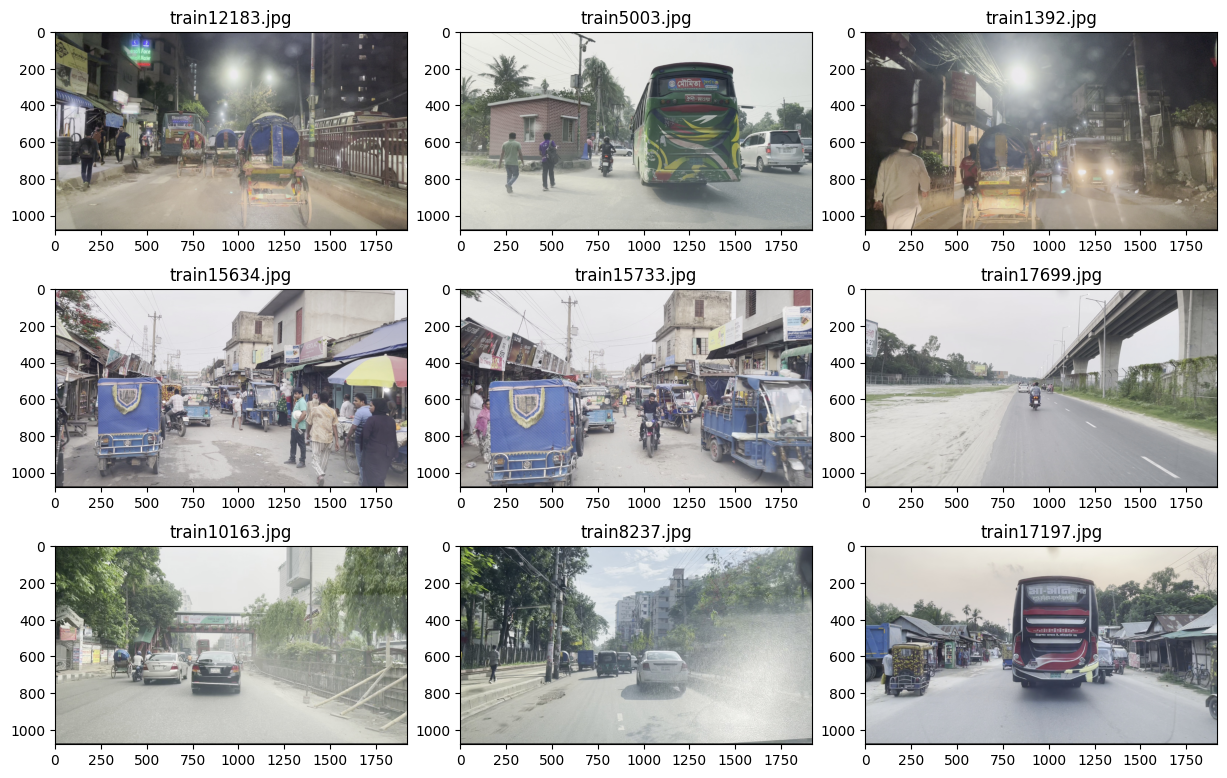

In [54]:
def show_ima_matrix(image_list, show_axis=False):
    MAX_SIZE = 9
    if len(image_list) != MAX_SIZE:
        raise(f"Se requieren exactamente {MAX_SIZE} imágenes para crear la matriz.")

    plt.figure(figsize=(15, 10))
    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(wspace=0.15, hspace=0.005)
    for i in range(MAX_SIZE):
        ima_file = image_list[i]
        ima_name = os.path.basename(ima_file)
        ax = plt.subplot(gs1[i])
        plt.imshow(np.array(Image.open(ima_file)))
        plt.title(ima_name[:20])
        plt.axis("on" if show_axis else "off")
    plt.show()
show_ima_matrix(selected_images, show_axis=True)

In [55]:
def verify_alignment(folder_dict):
    """
    Verifies alignment between images and corresponding label files.

    Args:
        folder_dict (dict): Dictionary containing image and label folder paths.

    Returns:
        None: Prints images without labels and labels without images for each folder.
    """
    categories = ['train', 'test', 'val']
    
    for category in categories:
        img_folder = folder_dict[f'images_{category}']
        lbl_folder = folder_dict[f'labels_{category}']
        
        img_files = {f.stem for f in img_folder.iterdir() if f.suffix.lower() in IMAGE_EXT}
        lbl_files = {f.stem for f in lbl_folder.iterdir() if f.suffix.lower() in LABEL_EXT}

        imgs_without_labels = img_files - lbl_files
        if imgs_without_labels:
            print(f"Imágenes sin etiquetas en la carpeta {img_folder}: {', '.join(imgs_without_labels)}")

        labels_without_imgs = lbl_files - img_files
        if labels_without_imgs:
            print(f"Etiquetas sin imágenes en la carpeta {lbl_folder}: {', '.join(labels_without_imgs)}")

verify_alignment(folder_dict)

In [68]:
def create_datasets(folder_dict, batch_size=32, image_size=(640, 640)):
    """
    Creates TensorFlow datasets for training and validation with streaming data loading.

    Args:
        folder_dict (dict): Dictionary containing folder paths for images and labels.
        batch_size (int): Size of the data batches for training and validation.
        image_size (tuple): Size to which images will be resized (height, width).

    Returns:
        train_dataset (tf.data.Dataset): Streaming dataset for training.
        val_dataset (tf.data.Dataset): Streaming dataset for validation.
    """
    def create_image_and_label_paths(image_folder, label_folder):
        """
        Generates lists of image paths and corresponding label paths.

        Args:
            image_folder (Path): Folder containing images.
            label_folder (Path): Folder containing labels.

        Returns:
            image_paths (list): List of image paths.
            label_paths (list): List of corresponding label paths.
        """
        image_paths = sorted(list(image_folder.glob('*.jpg')))
        label_paths = [label_folder / img_path.with_suffix('.txt').name for img_path in image_paths]
        return image_paths, label_paths

    def load_image_and_label(image_path, label_path):
        """
        Loads an image and its corresponding label.

        Args:
            image_path (str): Path to the image.
            label_path (str): Path to the label.

        Returns:
            image (tensor): Resized and normalized image.
            label (tensor): Label as an integer.
        """
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, image_size)
        image = image / 255.0

        label = tf.io.read_file(label_path)
        label = tf.strings.strip(label)
        label = tf.strings.split(label, '\n') ## <-- Changed

        # Added ..
        label = tf.strings.split(label)
        label = tf.strings.to_number(label, out_type=tf.float32)

        return image, label

    def image_label_generator(image_paths, label_paths):
        """
        Generates image-label pairs in streaming mode.

        Args:
            image_paths (list): List of image paths.
            label_paths (list): List of corresponding label paths.

        Yields:
            image (tensor): Resized and normalized image.
            label (tensor): Label as an integer.
        """
        for img_path, lbl_path in zip(image_paths, label_paths):
            yield str(img_path), str(lbl_path)

    # Paths
    train_image_paths, train_label_paths = create_image_and_label_paths(
        folder_dict['images_train'], folder_dict['labels_train']
    )
    
    val_image_paths, val_label_paths = create_image_and_label_paths(
        folder_dict['images_val'], folder_dict['labels_val']
    )

    # Streaming datasets
    train_dataset = tf.data.Dataset.from_generator(
        lambda: image_label_generator(train_image_paths, train_label_paths),
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string)
        )
    )
    train_dataset = train_dataset.map(
        lambda img, lbl: load_image_and_label(img, lbl), num_parallel_calls=tf.data.AUTOTUNE
    )
    train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_generator(
        lambda: image_label_generator(val_image_paths, val_label_paths),
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string)
        )
    )
    val_dataset = val_dataset.map(
        lambda img, lbl: load_image_and_label(img, lbl), num_parallel_calls=tf.data.AUTOTUNE
    )
    val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, val_dataset

In [69]:
# Example usage
train_dataset, val_dataset = create_datasets(folder_dict, batch_size=32, image_size=(640, 640))

# Verify dataset structure
for image, label in train_dataset.take(1):
    print("Image shape:", image.numpy().shape)
    print("Label:", label.numpy())

Image shape: (32, 640, 640, 3)
Label: [array([[1.       , 0.367188 , 0.640741 , 0.0260417, 0.0907407],
        [7.       , 0.279687 , 0.666667 , 0.0291667, 0.0796296],
        [6.       , 0.401563 , 0.635648 , 0.0322917, 0.0453704],
        [1.       , 0.335677 , 0.651852 , 0.0390625, 0.12963  ],
        [8.       , 0.307292 , 0.697222 , 0.0395833, 0.1      ],
        [3.       , 0.457552 , 0.655556 , 0.0578125, 0.12037  ],
        [1.       , 0.0802083, 0.728704 , 0.160417 , 0.511111 ]],
       dtype=float32)
 array([[7.       , 0.985417 , 0.660648 , 0.0291667, 0.0972222],
        [6.       , 0.841406 , 0.642593 , 0.259896 , 0.185185 ],
        [5.       , 0.452083 , 0.723148 , 0.435417 , 0.535185 ]],
       dtype=float32)
 array([[1.      , 0.224479, 0.652315, 0.0375  , 0.128704],
        [1.      , 0.347396, 0.658796, 0.044792, 0.141667],
        [2.      , 0.89974 , 0.810185, 0.164062, 0.253704],
        [1.      , 0.783854, 0.671759, 0.05    , 0.132407],
        [1.      , 0.27578

In [70]:
folder_dict

{'images_test': PosixPath('data/preprocessed/data2/rsud20k/images/test'),
 'images_train': PosixPath('data/preprocessed/data2/rsud20k/images/train'),
 'images_val': PosixPath('data/preprocessed/data2/rsud20k/images/val'),
 'labels_test': PosixPath('data/preprocessed/data2/rsud20k/labels/test'),
 'labels_train': PosixPath('data/preprocessed/data2/rsud20k/labels/train'),
 'labels_val': PosixPath('data/preprocessed/data2/rsud20k/labels/val')}

In [76]:
folder_dict["labels_test"]

PosixPath('data/preprocessed/data2/rsud20k/labels/test')

In [78]:
yaml_content = f"""
# Ruta raíz de las imágenes y etiquetas
train: {folder_dict["images_train"]}   # Ruta a las imágenes de entrenamiento
val: {folder_dict["images_val"]}       # Ruta a las imágenes de validación
test: {folder_dict["images_test"]}     # Ruta a las imágenes de prueba (opcional)

# Rutas a las etiquetas (opcional si se necesita)
train_labels: {folder_dict["labels_train"]}   # Ruta a las etiquetas de entrenamiento
val_labels: {folder_dict["labels_val"]}       # Ruta a las etiquetas de validación
test_labels: {folder_dict["labels_test"]}     # Ruta a las etiquetas de prueba (opcional)

# Clases que el modelo debe detectar
names:
  0: person
  1: rickshaw
  2: rickshaw van
  3: auto rickshaw
  4: truck
  5: pickup truck
  6: private car
  7: motorcycle
  8: bicycle
  9: bus
  10: micro bus
  11: covered van
  12: human hauler
"""

with open('data/settings.yaml', 'w') as file:
    file.write(yaml_content)

! cat data/settings.yaml


# Ruta raíz de las imágenes y etiquetas
train: data/preprocessed/data2/rsud20k/images/train   # Ruta a las imágenes de entrenamiento
val: data/preprocessed/data2/rsud20k/images/val       # Ruta a las imágenes de validación
test: data/preprocessed/data2/rsud20k/images/test     # Ruta a las imágenes de prueba (opcional)

# Rutas a las etiquetas (opcional si se necesita)
train_labels: data/preprocessed/data2/rsud20k/labels/train   # Ruta a las etiquetas de entrenamiento
val_labels: data/preprocessed/data2/rsud20k/labels/val       # Ruta a las etiquetas de validación
test_labels: data/preprocessed/data2/rsud20k/labels/test     # Ruta a las etiquetas de prueba (opcional)

# Clases que el modelo debe detectar
names:
  0: person
  1: rickshaw
  2: rickshaw van
  3: auto rickshaw
  4: truck
  5: pickup truck
  6: private car
  7: motorcycle
  8: bicycle
  9: bus
  10: micro bus
  11: covered van
  12: human hauler
